# How to use the unit system

Here, we show some examples using the unit system in `ecell4`. This feature requires Python library, `pint`. Install `pint` before running this example as follows: `pip install pint`. See also the website https://pint.readthedocs.io/en/latest/.

In [1]:
%matplotlib inline
from ecell4 import *

## With no units

First, imagine a very simple system only with binding and unbinding reactions like:

In [2]:
with species_attributes():
    A | B | C | {'D': 1, 'radius': 0.005}

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

The `species_attributes` section defines a diffusion constant and radius of `Species`, `A`, `B` and `C`. For example, the diffusion rate of `A` is `1`, and its dimensionality is expected to be `[length**2/time]`. However, what is the scale? Is it `meter`? Or `mile`?

Once the base units are determined, e.g. `micrometer` as `[length]` and `second` as `[time]`, all the units must be consistent within the model. The second order rate consant must have dimensionality `[1/(substance/length**3)/time]`, which is `micrometer**3/item/second`. Thus, when the parameter is given as `1/molar/min` in some literature, you have to translate it by yourself.

In [3]:
show(m)

A|{'D': 1, 'radius': 0.005}
B|{'D': 1, 'radius': 0.005}
C|{'D': 1, 'radius': 0.005}
A+B>C|0.01
C>A+B|0.3


## Introducing units

`ecell4` provides the way to handle units in the modeling environment. Here is an example.

In [4]:
from ecell4.extra.unit import getUnitRegistry

In [5]:
ureg = getUnitRegistry()
Q_ = ureg.Quantity

with species_attributes():
    A | B | C | {'D': Q_(1, 'um**2/s'), 'radius': Q_(0.005, 'um')}

with reaction_rules():
    A + B == C | (Q_(0.01, '1/(item/um**3)/s'), Q_(0.3, '1/s'))

m = get_model()

First, create your own unit system,`ureg`, by using `ecell4.extra.unit.getUnitRegistry`. With this `UnitRegistry`, you can make a quantity with its unit as `ureg.Quantity(value, unit)`. (Please be careful about the type of `Quantity`. It looks same with `Quantity` given by `pint`, but is slightly changed in `ecell4` though all the original functionality in `pint` is availble even in `ecell4`. Please not use `ureg = pint.UnitRegistry()`.)

In [6]:
help(ureg.Quantity)

Help on class Quantity in module pint.quantity:

class Quantity(_Quantity)
 |  Implements a class to describe a physical quantity:
 |  the product of a numerical value and a unit of measurement.
 |  
 |  :param value: value of the physical quantity to be created.
 |  :type value: str, Quantity or any numeric type.
 |  :param units: units of the physical quantity to be created.
 |  :type units: UnitsContainer, str or Quantity.
 |  
 |  Method resolution order:
 |      Quantity
 |      _Quantity
 |      pint.util.SharedRegistryObject
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__ = wrapped(self, other)
 |  
 |  __div__ = wrapped(self, other)
 |  
 |  __mul__ = wrapped(self, other)
 |  
 |  __pow__ = wrapped(self, other)
 |  
 |  __truediv__ = wrapped(self, other)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  force_ndarray = False
 |  
 |  ---------------------------------------

The default base units are `meter` for `[length]`, `second` for `[time]`, and `item` (which means the number of molecules) for `[substance]`. When you change the default base unit, do like `ureg = getUnitRegistry(length='micrometer')`.

In [7]:
show(m)

A|{'D': 1e-12, 'radius': 5e-09}
B|{'D': 1e-12, 'radius': 5e-09}
C|{'D': 1e-12, 'radius': 5e-09}
A+B>C|1e-20
C>A+B|0.3


Now you can provide quantities in any unit regardless of the base units.

In [8]:
ureg = getUnitRegistry()
Q_ = ureg.Quantity

with species_attributes():
    A | B | C | {'D': Q_(1e-8, 'cm**2/s'), 'radius': Q_(5, 'nm')}

with reaction_rules():
    A + B == C | (Q_(6.02214129, '1/uM/s'), Q_(18, '1/min'))

m = get_model()
show(m)

A|{'D': 1e-12, 'radius': 5e-09}
B|{'D': 1e-12, 'radius': 5e-09}
C|{'D': 1e-12, 'radius': 5e-09}
A+B>C|1e-20
C>A+B|0.3


You can operate quantities, and make a new quantity. See https://pint.readthedocs.io/en/latest/ for more details.

In [9]:
volume = Q_(1, 'fL')
conc = Q_(100, 'nM')
print((volume * conc).to('item'))

60.221412900000004 item


In addition to the model creation, `run_simulation` (and `ensemble_simulations`) also supports the unit system.

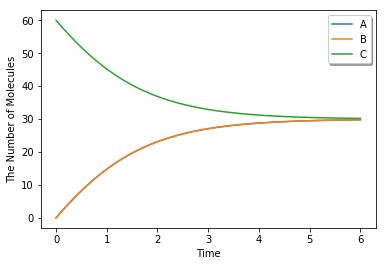

In [10]:
run_simulation(Q_(0.1, 'min'), y0={'C': Q_(60, 'item')}, volume=Q_(1, 'fL'), model=m, solver='ode')

Even if you change the base units, the behavior of simulations is kept consistent. In the following example, base units are rescaled to `micrometer` and `minute` with no change in the modeling section.

A|{'D': 60.000000000000014, 'radius': 0.005}
B|{'D': 60.000000000000014, 'radius': 0.005}
C|{'D': 60.000000000000014, 'radius': 0.005}
A+B>C|0.6
C>A+B|18


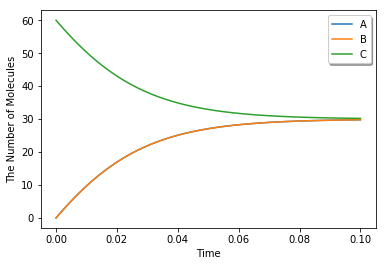

In [11]:
ureg = getUnitRegistry(length='micrometer', time='minute')
Q_ = ureg.Quantity

with species_attributes():
    A | B | C | {'D': Q_(1e-8, 'cm**2/s'), 'radius': Q_(5, 'nm')}

with reaction_rules():
    A + B == C | (Q_(6.02214129, '1/uM/s'), Q_(18, '1/min'))

m = get_model()
show(m)
run_simulation(Q_(0.1, 'min'), y0={'C': Q_(60, 'item')}, volume=Q_(1, 'fL'), model=m, solver='ode')

## Checking dimensionality

As default, the dimensionality of units is checked. When you turn off unit checking, call `ecell4.extra.unit.use_strict(False)` before using those features.

For example, the dimensionality of a diffusion constant must be `[length**2/time]`. When you give a unit with a wrong dimensionality, an exception would be thrown like:

In [12]:
try:
    with species_attributes():
        A | {'D': Q_(1.0, 'um/s')}
except ValueError as e:
    print('{}: {}'.format(e.__class__.__name__, e))

ValueError: Cannot convert [D] from '[length] / [time]' (micrometer / second) to '[length]**2/[time]'


Similarly, a kinetic rate constant of reactions is verified based on the order of the reaction. The first order reaction rate should have `[1/time]`, and the second order should have `[l/(substance/length**3)/time]` in volume.

try:
    with reaction_rules():
        A + B > C | Q_(0.3, '1/s')
except ValueError as e:
    print('{}: {}'.format(e.__class__.__name__, e))

Additionally, rate law representations accept quantities with a unit too. See the example below:

In [13]:
ureg = getUnitRegistry()
Q_ = ureg.Quantity

with reaction_rules():
    S > P | Q_(1.0, 'uM/s') * S / (Q_(100, 'nM') + S)

m = get_model()
show(m)

S>P|((6.02214129e+20*S)/(6.02214129e+19+S))


Here, the reaction above has two quantities, `Vmax = Q_(1.0, 'uM/s')` and `Km = Q_(100, 'nM')`. First, `Km` must have the same dimensionality with `S`, which is `[concentration]`.

In [14]:
try:
    with reaction_rules():
        S > P | Q_(1.0, 'uM/s') * S / (Q_(100, 'nM/s') + S)
except ValueError as e:
    print('{}: {}'.format(e.__class__.__name__, e))

DimensionalityError: Cannot convert from 'item / meter ** 3 / second' ([substance] / [length] ** 3 / [time]) to 'item / meter ** 3' ([substance] / [length] ** 3)


Secondly, the dimensionality of a rate equation must be `[concentration/time]`. Therefore, the dimensionality of `Vmax` should be `[concentration/time]` too.

In [15]:
try:
    with reaction_rules():
        S > P | Q_(1.0, '1/s') * S / (Q_(100, 'nM') + S)
except RuntimeError as e:
    print('{}: {}'.format(e.__class__.__name__, e))

RuntimeError: A rate law must have dimension '[substance] / [length] ** 3 / [time]'. '1 / [time]' was given.


When you give a value with no unit, it is regarded as `dimensionless`.

In [16]:
with reaction_rules():
    S > P | 10.0 * Q_(0.1, 'uM/s') * S**2 / (Q_(100, 'nM')**2 + S**2)
m = get_model()
show(m)

S>P|((6.02214129e+20*pow(S,2))/(3.626618571672287e+39+pow(S,2)))


## Table generation

Not yet.